Install the required packages and import all the important libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00


In [3]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow_addons as tfa

In [5]:
#import all the libraries
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image  import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Data Preperation

In [ ]:
!unzip "/content/drive/MyDrive/archive (1).zip" -d "/content/Data"

In [ ]:
images = os.listdir("/content/Data/train/images")
images

In [8]:
os.mkdir("train")
os.mkdir("test")
os.mkdir("validation")

In [9]:
train_df = pd.read_csv("/content/Data/train/train.csv")
test_df = pd.read_csv("/content/Data/test_ApKoW4T.csv")

In [11]:
#0.15 percent validaiton split
train,validation = train_test_split(train_df,test_size=0.15, random_state=42)

In [12]:
#create a seprate folders for different classes
for i in range(1,6):
  os.mkdir(f"/content/train/{i}")
  os.mkdir(f"/content/validation/{i}")

In [13]:
img_path = "/content/Data/train/images/"
train_path = "/content/train"
validation_path = "/content/validation"


for i in range(len(train)): #training data
  img = train['image'].iloc[i]
  tar = train['category'].iloc[i]
  shutil.move(img_path + img, train_path + f"/{tar}")


for i in range(len(validation)):
  img = validation['image'].iloc[i]
  tar = validation['category'].iloc[i]
  shutil.move(img_path + img,validation_path + f"/{tar}")

data is prepared!

# Loading the data & applying augumentation.

In [14]:
train_datagen = ImageDataGenerator(rescale = 1/255,rotation_range=45, 
                             horizontal_flip=True, 
                             width_shift_range=0.5, 
                             height_shift_range=0.5, 
                             vertical_flip=True,
                             zoom_range=[1.0,1.5],
                             dtype='float32')

val_datagen = ImageDataGenerator(rescale = 1/255)

In [15]:
train_gen = train_datagen.flow_from_directory("/content/train",batch_size = 64, class_mode = "categorical", target_size = (224,224))
val_gen = val_datagen.flow_from_directory("/content/validation",batch_size = 64, class_mode = "categorical", target_size = (224,224))

Found 5314 images belonging to 5 classes.
Found 938 images belonging to 5 classes.


# EDA

In [16]:
ship = {'Cargo': 1, 
'Military': 2, 
'Carrier': 3, 
'Cruise': 4, 
'Tankers': 5}

In [17]:
# reverse the ship type dictionary
ship = dict([[v,k] for k,v in ship.items()])

In [18]:
# Create test labels for interpretability
train_df['ship'] = train_df['category'].map(ship).astype('object')
labels = list(train_df['ship'].unique())

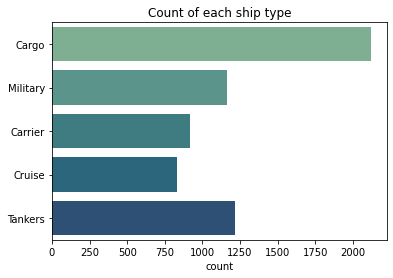

In [19]:
# display count of ship types Complete data
plt.title('Count of each ship type')
sns.countplot(y=train_df['ship'].values,palette="crest")
plt.show()

([<matplotlib.patches.Wedge at 0x7f3f67a30640>,
 [Text(1.0515966099968117, 1.932393482146743, 'Cargo - 34.14%'),
  Text(-2.0189672487507835, 0.8739400714417966, 'Military - 18.72%'),
  Text(-1.7665963298519827, -1.3111588032551609, 'Carrier - 14.60%'),
  Text(-0.12479252868031213, -2.1964577903491738, 'Cruise - 13.27%'),
  Text(1.8090287253004025, -1.2519644847350913, 'Tankers - 19.27%')])

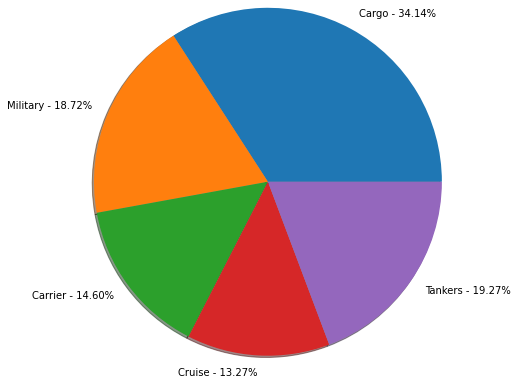

In [20]:
 wedge = [train['category'].value_counts()[1],train['category'].value_counts()[2],
         train['category'].value_counts()[3],train['category'].value_counts()[4],
         train['category'].value_counts()[5]]

perc = [train['category'].value_counts()[1]/len(train),
        train['category'].value_counts()[2]/len(train),
        train['category'].value_counts()[3]/len(train),
        train['category'].value_counts()[4]/len(train),
        train['category'].value_counts()[5]/len(train),
       ]
plt.pie(wedge,labels=['Cargo - '+ format(perc[0]*100, '.2f') + '%','Military - '+ format(perc[1]*100, '.2f') + '%','Carrier - '+ format(perc[2]*100, '.2f') + '%','Cruise - '+ format(perc[3]*100, '.2f') + '%','Tankers - '+ format(perc[4]*100, '.2f') + '%'],
        shadow=True,radius = 2.0)

([<matplotlib.patches.Wedge at 0x7f3f67a04700>,
 [Text(1.1422633318841875, 1.880221923240136, 'Cargo - 32.62%'),
  Text(-1.9137941307475497, 1.085076967369703, 'Military - 18.34%'),
  Text(-1.8990858340406636, -1.1106182939903693, 'Carrier - 14.93%'),
  Text(-0.3230346301777176, -2.17615455051013, 'Cruise - 13.54%'),
  Text(1.7561602779324146, -1.3251041763621245, 'Tankers - 20.58%')])

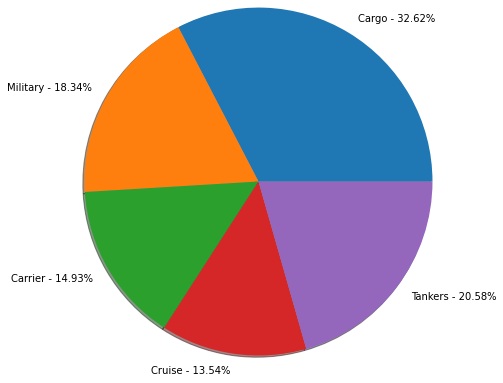

In [21]:
wedge = [validation['category'].value_counts()[1],validation['category'].value_counts()[2],
         validation['category'].value_counts()[3],validation['category'].value_counts()[4],
         validation['category'].value_counts()[5]]

perc = [validation['category'].value_counts()[1]/len(validation),
        validation['category'].value_counts()[2]/len(validation),
        validation['category'].value_counts()[3]/len(validation),
        validation['category'].value_counts()[4]/len(validation),
        validation['category'].value_counts()[5]/len(validation),
       ]
plt.pie(wedge,labels=['Cargo - '+ format(perc[0]*100, '.2f') + '%','Military - '+ format(perc[1]*100, '.2f') + '%','Carrier - '+ format(perc[2]*100, '.2f') + '%','Cruise - '+ format(perc[3]*100, '.2f') + '%','Tankers - '+ format(perc[4]*100, '.2f') + '%'],
        shadow=True,radius = 2.0)

In [22]:
train_df['category'].value_counts(normalize = True)

1    0.339091
5    0.194658
2    0.186660
3    0.146513
4    0.133077
Name: category, dtype: float64

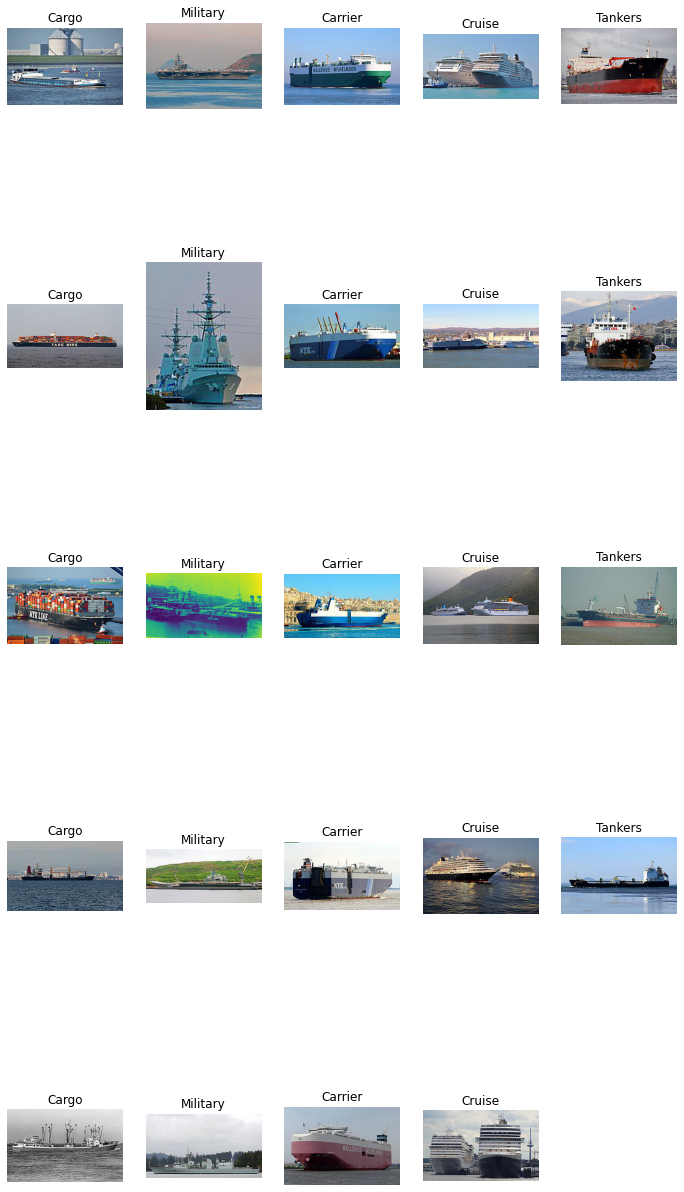

In [23]:
# visualize the top 28 train images
plt.figure(figsize=(12,24))

for i in range(1,25): 
  if(i%5==0):
    j = i
    path = f"/content/train/{5}"
    n = 5
  else:
    j = i%5
    path = f"/content/train/{j}"
    n = j
  plt.subplot(5,5,i)
  jl = os.listdir(path)
  plt.title(f'{ship[n]}')
  img = plt.imread(path + "/" + jl[i])
  plt.imshow(img)
  plt.axis('off')
plt.show()

# Modelling

In [24]:
base_model = Xception(include_top=False, input_shape=(224,224,3))

83683744/83683744 [==============================] - 5s 0us/step


In [25]:
# base_model = ResNet50(input_shape = (224, 224, 3), # Shape of our images
# include_top = False, # Leave out the last fully connected layer
# weights = 'imagenet')

In [26]:
# base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
# include_top = False, # Leave out the last fully connected layer
# weights = 'imagenet')

In [27]:
# for layer in base_model.layers:
#     layer.trainable = False

In [28]:
# Flatten the output layer to 1 dimension
# x = layers.Flatten()(base_model.output)
 
# Add a fully connected layer with 512 hidden units and ReLU activation
#x = layers.Dense(512, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(base_model.output)
 
# Add a dropout rate of 0.5
#x = layers.D/ropout(0.5)(x)
 
# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(5, activation='softmax')(x)
 
model = tf.keras.models.Model(base_model.input, x)
 
model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0003), loss = 'categorical_crossentropy',metrics = [tfa.metrics.CohenKappa(num_classes=5),tfa.metrics.F1Score(num_classes=5),'categorical_accuracy',])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [30]:
os.mkdir("Saved Model")

In [31]:
mc = ModelCheckpoint("/content/Saved Model/best_model.h5",monitor='val_cohen_kappa', mode='max', verbose=1, save_best_only=True)

In [32]:
reshist = model.fit(train_gen, validation_data = val_gen,epochs = 30,verbose=1,callbacks = [mc])

Epoch 1/30
84/84 [==============================] - ETA: 0s - loss: 0.6814 - cohen_kappa: 0.6553 - f1_score: 0.7414 - categorical_accuracy: 0.7364
Epoch 1: val_cohen_kappa improved from -inf to 0.82743, saving model to /content/Saved Model/best_model.h5
84/84 [==============================] - 128s 1s/step - loss: 0.6814 - cohen_kappa: 0.6553 - f1_score: 0.7414 - categorical_accuracy: 0.7364 - val_loss: 0.4154 - val_cohen_kappa: 0.8274 - val_f1_score: 0.8762 - val_categorical_accuracy: 0.8667
Epoch 2/30
84/84 [==============================] - ETA: 0s - loss: 0.3750 - cohen_kappa: 0.8165 - f1_score: 0.8689 - categorical_accuracy: 0.8583
Epoch 2: val_cohen_kappa improved from 0.82743 to 0.83597, saving model to /content/Saved Model/best_model.h5
84/84 [==============================] - 109s 1s/step - loss: 0.3750 - cohen_kappa: 0.8165 - f1_score: 0.8689 - categorical_accuracy: 0.8583 - val_loss: 0.4123 - val_cohen_kappa: 0.8360 - val_f1_score: 0.8805 - val_categorical_accuracy: 0.8721
E

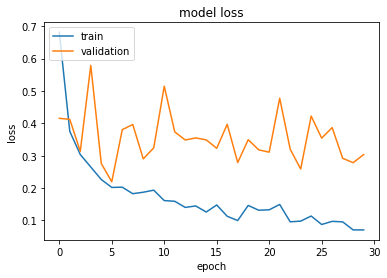

In [33]:
plt.plot(reshist.history['loss'])
plt.plot(reshist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

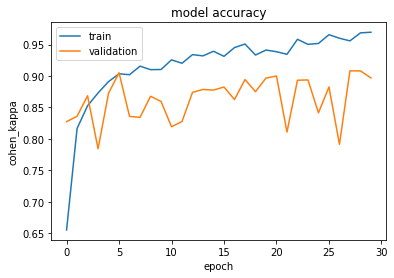

In [34]:
plt.plot(reshist.history['cohen_kappa'])
plt.plot(reshist.history['val_cohen_kappa'])
plt.title('model accuracy')
plt.ylabel('cohen_kappa')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()